In [28]:
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

import torch
import torch.nn as nn

import time

# Interval is [0.5, 2.5]

In [29]:
class DeepliftingSimpleModel(nn.Module):
    def __init__(
        self,
    ):
        super(DeepliftingSimpleModel, self).__init__()

        # # One simple linear layer the input size will be 3
        # self.intermediate_linear_layer = nn.Linear(2, 2)

        self.linear_layer = nn.Linear(2, 1, bias=False)

        # # Simple input
        # self.x = nn.Parameter(torch.randn(1, 2))

    def get_linear_layer(self, inputs):
        return self.intermediate_linear_layer(inputs)

    def get_output_layer(self, inputs):
        output = self.linear_layer(inputs)
        return output

    def forward(self, inputs=None):
        if inputs is None:
            x = self.x
        else:
            x = inputs

        output = self.get_output_layer(x)

        # a & b are known for this example
        a, b = 0.5, 2.5
        return a + (b - a) / 2.0 * (torch.sin(output) + 1)
        return output


def objective(x):
    return torch.sin(10 * torch.pi * x) / (2 * x) + (x - 1) ** 4


def deeplifting_fn(x, model, objective, weights_list):
    """
    Combined funtion used for PyGranso
    """
    outputs = model(inputs=x)

    # Save the weights
    weights = [weights for name, weights in model.named_parameters()]
    weights_list.append(weights[0].detach().cpu().numpy())

    # Get x1 and x2 so we can add the bounds
    # outputs = torch.sigmoid(outputs)
    # x = outputs.mean(axis=0)
    # print(f'Output x {x}')
    f = objective(outputs)

    # Inequality constraint
    ci = None

    # Equality constraing
    ce = None

    return f, ci, ce

In [33]:
device = torch.device('cpu')

# Deeplifting model with skip connections
model = DeepliftingSimpleModel()
model = model.to(device=device, dtype=torch.double)

model.train()
nvar = getNvarTorch(model.parameters())

# Setup a pygransoStruct for the algorithm
# options
opts = pygransoStruct()

# Inital x0
x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 1
opts.limited_mem_size = 5
opts.stat_l2_model = False
opts.double_precision = True
opts.opt_tol = 1e-10
opts.maxit = 1000

x = torch.randn(1, 2)
x = x.to(device=device, dtype=torch.double)

# Set up the function with the results
# # Combined function
weights_list = []
comb_fn = lambda model: deeplifting_fn(
    x,
    model,
    objective,
    weights_list,
)  # noqa

# Run the main algorithm
start_time = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end_time = time.time()
total_time = end_time - start_time



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

In [35]:
x

tensor([[0.5927, 1.2537]], dtype=torch.float64)

In [34]:
import numpy as np

np.vstack(weights_list)

array([[  0.62724203,  -0.21762332],
       [ -5.67368269, -13.54614716],
       [ -4.52508269, -11.11648116],
       [ -5.09938269, -12.33131416],
       [ -5.38653269, -12.93873066],
       [ -5.60045292, -13.39124216],
       [ -5.6008685 , -13.39212124],
       [ -5.60066071, -13.3916817 ],
       [ -5.60055681, -13.39146193],
       [ -5.60050487, -13.39135204],
       [ -5.60050141, -13.39134474],
       [ -5.60050141, -13.39134473]])

In [ ]:
z = torch.randn(512, 2).to(device=device, dtype=torch.double)
z

In [ ]:
# z * W + b

output = model.get_linear_layer(z)
output.shape

# model.get_output_layer(output)

In [ ]:
x_min, x_max, y_min, y_max = (
    model.get_linear_layer(inputs)[:, 0].min(),
    model.get_linear_layer(inputs)[:, 0].max(),
    model.get_linear_layer(inputs)[:, 1].min(),
    model.get_linear_layer(inputs)[:, 1].max(),
)

x_min = float(x_min.detach().cpu().numpy())
x_max = float(x_max.detach().cpu().numpy())
y_min = float(y_min.detach().cpu().numpy())
y_max = float(y_max.detach().cpu().numpy())

x_min, x_max

In [ ]:
x = torch.linspace(x_min, x_max, steps=50)
y = torch.linspace(y_min, y_max, steps=50)

In [ ]:
x_flat = torch.meshgrid(x, y)[0].flatten()
y_flat = torch.meshgrid(x, y)[1].flatten()

In [ ]:
inputs = torch.stack((x_flat, y_flat)).T.to(device=device, dtype=torch.double)

In [ ]:
Z = model.get_output_layer(inputs)

In [ ]:
Z = Z.reshape(50, 50).detach().cpu().numpy()

In [ ]:
X, Y = torch.meshgrid(x, y)
X = X.numpy()
Y = Y.numpy()

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Define the function
def f(x, y):
    return np.sin(np.sqrt(x**2 + y**2))


# # Create a meshgrid for our x, y values
# x = np.linspace(-5, 5, 100)
# y = np.linspace(-5, 5, 100)
# X, Y = np.meshgrid(x, y)
# Z = f(X, Y)

# Set up a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a surface
ax.plot_surface(X, Y, Z, cmap='YlOrRd')

In [ ]:
plt.figure()

# Create a contour plot
contour = plt.contourf(
    X, Y, Z, 20, cmap='YlOrRd'
)  # contourf fills the regions between contours
plt.colorbar(contour)  # Show a colorbar that maps color to Z values

In [ ]:
plt.hist(Z.flatten())

In [ ]:
test_x = torch.linspace(0.5, 2.5, 1000)
np.argmin(objective(test_x).cpu().numpy())

In [ ]:
input = model.x
input

In [ ]:
intermedate_input = model.get_linear_layer(input)

In [ ]:
model.get_output_layer(intermedate_input)

In [ ]:
z = Z.flatten()

In [ ]:
f = objective(torch.tensor(z)).cpu().numpy()

In [ ]:
import seaborn as sns

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'z': z, 'f': f})

In [ ]:
sns.scatterplot(data=df, x='z', y='f')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the layout
layout = """
    AB
    CC
"""

fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(
    layout,
    per_subplot_kw={
        "A": {"projection": "3d"},
    },
)

# 3D Surface plot
ax3d = ax_dict['A']
ax3d.plot_surface(X, Y, Z, cmap='YlOrRd')
ax3d.set_title('Lifted Surface Plot')

# Contour plot
c = ax_dict['B'].contourf(X, Y, Z, 20, cmap='YlOrRd')
# divider = make_axes_locatable(ax_dict['B'])
# cax = divider.append_axes("bottom", size="5%", pad=0.01)
# fig.colorbar(c, cax=cax, orientation='horizontal')
fig.colorbar(c, ax=ax_dict['B'])
ax_dict['B'].set_title('Lifted Contour Plot')

# Histogram
ax_dict['C'].hist(Z.ravel(), bins=50, color='grey', alpha=0.7)
ax_dict['C'].set_title('Input Values from Lifted onto Original Space')
ax_dict['C'].set_xlabel('$x$ Values In Original Space')
ax_dict['C'].set_ylabel('Frequency')

plt.show()

In [ ]:
%pwd
%cd ../..

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the layout
layout = """
    AA
    BB
    CC
"""

fig = plt.figure(figsize=(6, 7))
ax_dict = fig.subplot_mosaic(
    layout,
)

# Contour plot
c = ax_dict['A'].contourf(X, Y, Z, 20, cmap='YlOrRd')
divider = make_axes_locatable(ax_dict['A'])
cax = divider.append_axes("bottom", size="15%", pad=0.0)
fig.colorbar(c, cax=cax, orientation='horizontal')
ax_dict['A'].axis('off')
ax_dict['A'].set_title('Lifted Contour Plot')

# Histogram
ax_dict['B'].hist(Z.ravel(), bins=50, color='grey', alpha=0.7)
ax_dict['B'].set_title('Input Values from Lifted onto Original Space')
ax_dict['B'].set_xlabel('$x$ Values In Original Space')
ax_dict['B'].set_ylabel('Frequency')

z = torch.tensor(Z.ravel())
f = objective(z).cpu().numpy()

ax_dict['C'].scatter(z, f)
ax_dict['C'].set_title('Gramacy and Lee Function')

plt.subplots_adjust(hspace=0.6)

# fig.tight_layout()
fig.savefig(
    './images/deeplifting_proof_of_concept.png', bbox_inches='tight', pad_inches=0.04
)

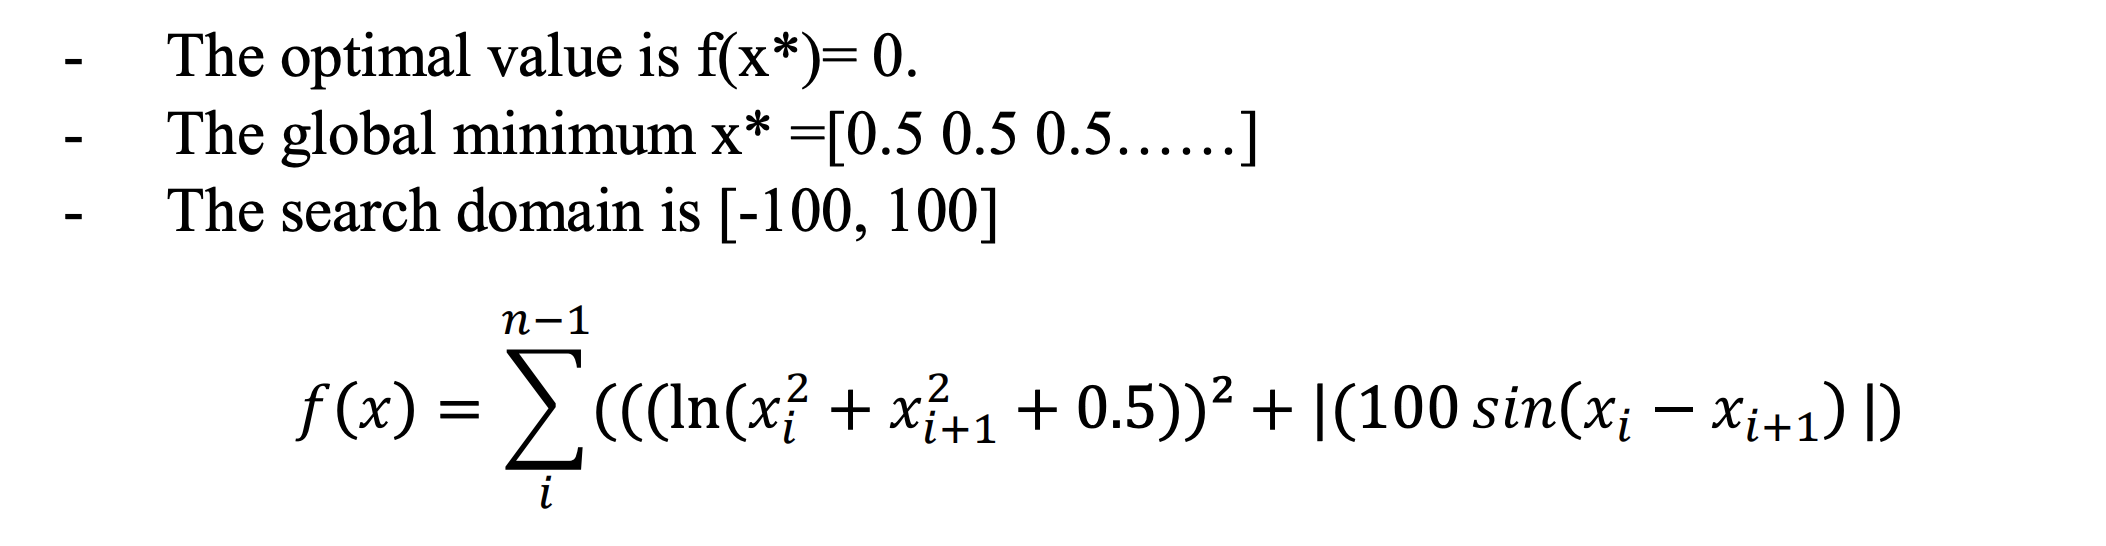

In [ ]:
x1, x2 = 0.5, 0.5
component1 = np.log(x1**2 + x2**2 + 0.5) ** 2
component2 = np.abs(100 * np.sin(x1 - x2))
print(component1 + component2)